<a href="https://colab.research.google.com/github/juanmed/epipolar_geometry/blob/main/Epipolar_geometry.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!pip install opencv-contrib-python==4.4.0.44

     |████████████████████████████████| 55.7MB 73kB/s 
  Found existing installation: opencv-contrib-python 4.1.2.30
    Uninstalling opencv-contrib-python-4.1.2.30:
      Successfully uninstalled opencv-contrib-python-4.1.2.30


In [ ]:
!wget https://raw.githubusercontent.com/opencv/opencv/master/samples/data/leuvenA.jpg
!wget https://raw.githubusercontent.com/opencv/opencv/master/samples/data/leuvenB.jpg
!wget https://raw.githubusercontent.com/opencv/opencv/master/samples/data/left01.jpg
!wget https://raw.githubusercontent.com/opencv/opencv/master/samples/data/right01.jpg
!wget https://raw.githubusercontent.com/juanmed/epipolar_geometry/main/1.png
!wget https://raw.githubusercontent.com/juanmed/epipolar_geometry/main/2.png

In [113]:
import numpy as np
import cv2 as cv
from matplotlib import pyplot as plt

def drawlines(img1,img2,lines,pts1,pts2):
    ''' img1 - image on which we draw the epilines for the points in img2
        lines - corresponding epilines '''
    r,c = img1.shape
    img1 = cv.cvtColor(img1,cv.COLOR_GRAY2BGR)
    img2 = cv.cvtColor(img2,cv.COLOR_GRAY2BGR)
    for r,pt1,pt2 in zip(lines,pts1,pts2):
        color = tuple(np.random.randint(0,255,3).tolist())
        x0,y0 = map(int, [0, -r[2]/r[1] ])
        x1,y1 = map(int, [c, -(r[2]+r[0]*c)/r[1] ])
        img1 = cv.line(img1, (x0,y0), (x1,y1), color,1)
        img1 = cv.circle(img1,tuple(pt1),5,color,-1)
        img2 = cv.circle(img2,tuple(pt2),5,color,-1)
    return img1,img2

img1 = cv.imread("1.png",0)  #queryimage # left image
img2 = cv.imread("2.png",0) #trainimage # right image
print(img1.shape,img2.shape)

(1536, 2048) (1536, 2048)


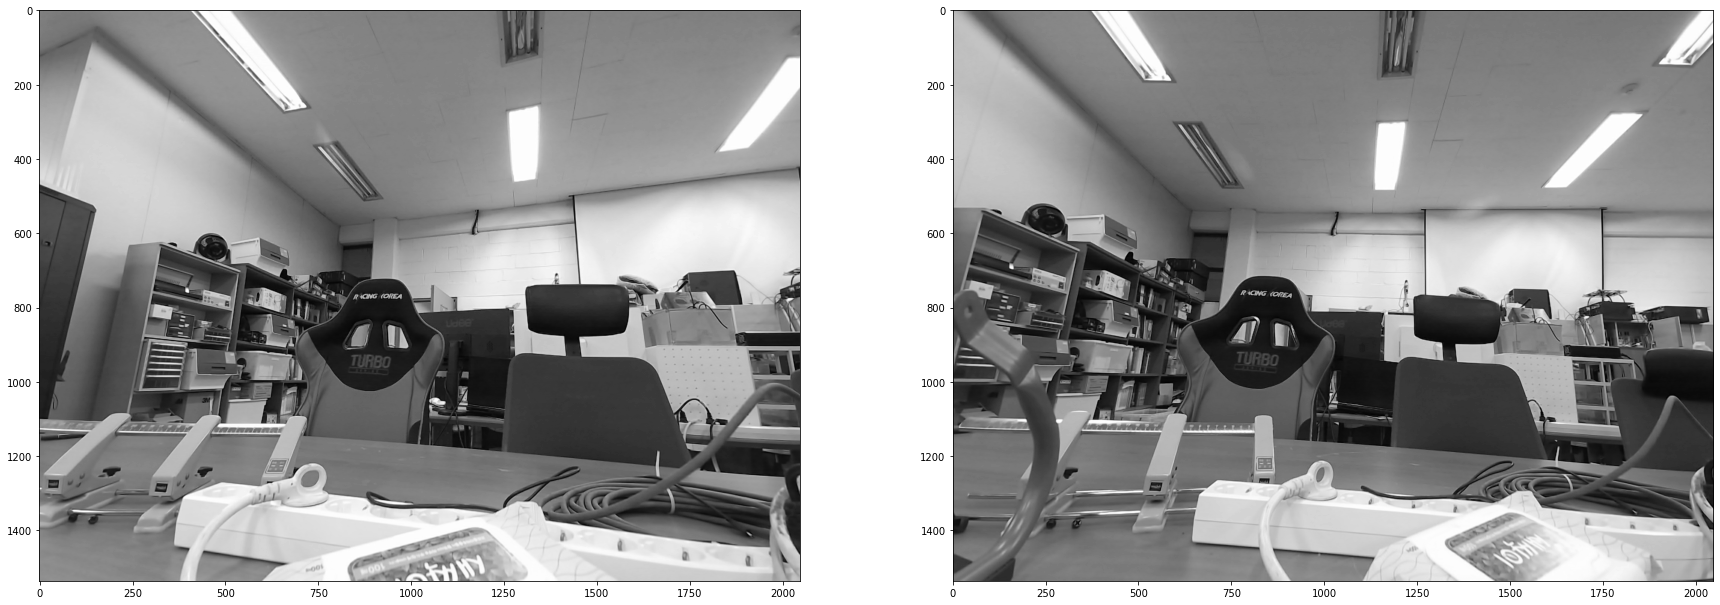

In [114]:
fig = plt.figure(figsize=(30,30))
ax1 = plt.subplot(1,2,1)
ax2 = plt.subplot(1,2,2)
ax1.imshow(img1, cmap="gray")
ax2.imshow(img2, cmap="gray")

In [115]:
d = None
# from https://github.com/opencv/opencv/blob/master/samples/data/essential_mat_data.txt
# for leuven images
K = np.array([651.4462353114224, 0, 376.27522319223914, 0, 653.7348054191838, 280.1106539526218,0, 0, 1]).reshape(3,3)
# for left01, right01 images from https://github.com/opencv/opencv/blob/master/samples/data/left_intrinsics.yml
#K =  np.array([5.3591573396163199e+02, 0., 3.4228315473308373e+02, 0., 5.3591573396163199e+02, 2.3557082909788173e+02, 0., 0., 1.]).reshape(3,3)
#d = np.array([-2.6637260909660682e-01, -3.8588898922304653e-02, 1.7831947042852964e-03, -2.8122100441115472e-04, 2.3839153080878486e-01])
# for 1.png, 2.png images
#d = np.array([0.4047389030456543, -2.626350164413452, 0.00027515311376191676, -5.470857649925165e-05, 1.6036430597305298, 0.285593181848526, -2.4465601444244385, 1.5245165824890137])
#K = np.array([963.1787109375, 0.0, 1020.224365234375, 0.0, 962.905517578125, 779.256591796875, 0.0, 0.0, 1.0]).reshape(3,3)

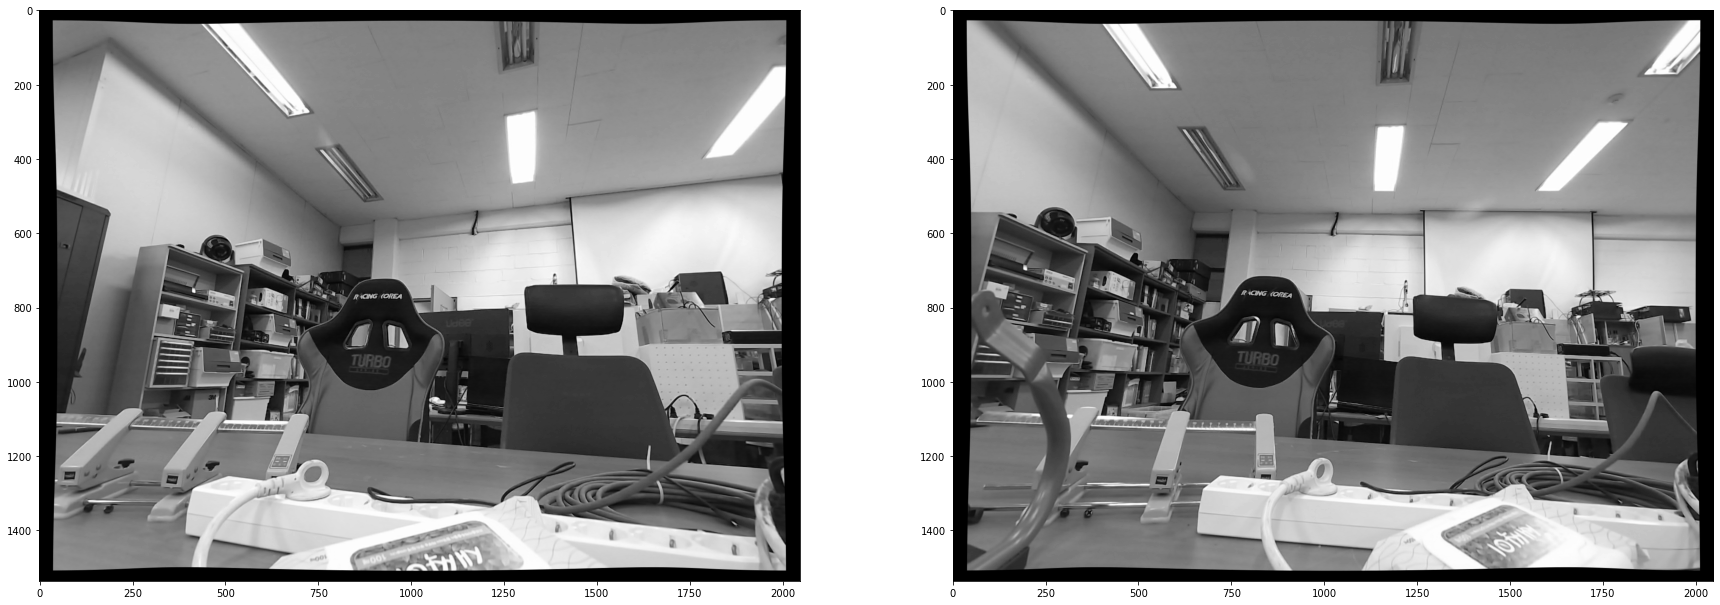

In [116]:
if d is not None:
  img1 =  cv.undistort(	img1, K, d)
  img2 =  cv.undistort(	img2, K, d)
fig = plt.figure(figsize=(30,30))
ax1 = plt.subplot(1,2,1)
ax2 = plt.subplot(1,2,2)
ax1.imshow(img1, cmap="gray")
ax2.imshow(img2, cmap="gray")

In [117]:
sift = cv.SIFT_create()
# find the keypoints and descriptors with SIFT
kp1, des1 = sift.detectAndCompute(img1,None)
kp2, des2 = sift.detectAndCompute(img2,None)
# FLANN parameters
FLANN_INDEX_KDTREE = 1
index_params = dict(algorithm = FLANN_INDEX_KDTREE, trees = 5)
search_params = dict(checks=50)
flann = cv.FlannBasedMatcher(index_params,search_params)
matches = flann.knnMatch(des1,des2,k=2)

pts1 = []
pts2 = []
# ratio test as per Lowe's paper
for i,(m,n) in enumerate(matches):
    if m.distance < 0.9*n.distance:
        pts2.append(kp2[m.trainIdx].pt)
        pts1.append(kp1[m.queryIdx].pt)

In [118]:
pts1 = np.int32(pts1)
pts2 = np.int32(pts2)

F, mask = cv.findFundamentalMat(pts1,pts2,cv.FM_LMEDS)
# We select only inlier points
pts1 = pts1[mask.ravel()>=1]
pts2 = pts2[mask.ravel()>=1]

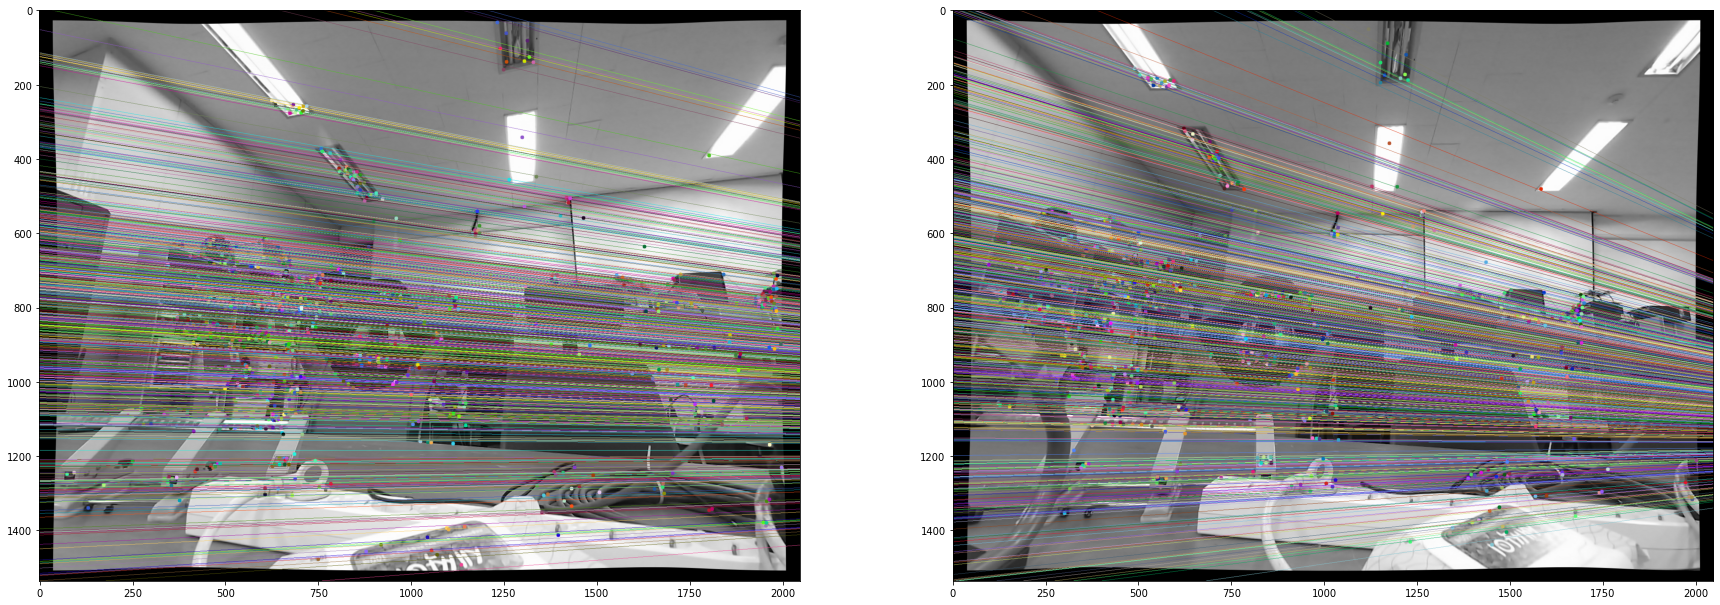

In [119]:
# Find epilines corresponding to points in right image (second image) and
# drawing its lines on left image
lines1 = cv.computeCorrespondEpilines(pts2.reshape(-1,1,2), 2,F)
lines1 = lines1.reshape(-1,3)
img5,img6 = drawlines(img1,img2,lines1,pts1,pts2)
# Find epilines corresponding to points in left image (first image) and
# drawing its lines on right image
lines2 = cv.computeCorrespondEpilines(pts1.reshape(-1,1,2), 1,F)
lines2 = lines2.reshape(-1,3)
img3,img4 = drawlines(img2,img1,lines2,pts2,pts1)

fig = plt.figure(figsize=(30,30))
ax1 = plt.subplot(1,2,1)
ax2 = plt.subplot(1,2,2)
ax1.imshow(img5)
ax2.imshow(img3)

In [120]:
E, mask =	cv.findEssentialMat(	pts1, pts2,K, cv.FM_LMEDS)
pts1 = pts1[mask.ravel()>=1]
pts2 = pts2[mask.ravel()>=1]
_, R, t, mask =	cv.recoverPose(	E, pts1, pts2, K)


In [121]:
print("Rotation: ", R)
print("Translation:", t)
print(_)

Rotation:  [[ 0.97926526 -0.06978109 -0.1901845 ]
 [ 0.06789515  0.99755729 -0.01642236]
 [ 0.19086591  0.00316924  0.981611  ]]
Translation: [[0.94952654]
 [0.13514414]
 [0.28308197]]
742


In [122]:
pts1 = pts1[mask.ravel()>=1]
pts2 = pts2[mask.ravel()>=1]

#Triangulation

In [123]:
T1 = np.dot(K , np.hstack((np.identity(3),np.zeros((3,1)))))
T2 = np.dot(K, np.hstack((R,t)))
homogeneous_points = cv.triangulatePoints(	T1, T2, pts1.T*1.0, pts2.T*1.0	)

In [124]:
##homogeneous_points = homogeneous_points.T*1.0
##for i in range(homogeneous_points.shape[0]):
## homogeneous_points[i] = homogeneous_points[i]/(homogeneous_points[i][3])
threeD_coords = cv.convertPointsFromHomogeneous(homogeneous_points.transpose()).reshape(-1,3)
xdata = threeD_coords[:,0]
ydata = threeD_coords[:,1]
zdata = threeD_coords[:,2]

#fx = 963.1787109375
#fy = 962.905517578125
#cx = 1020.224365234375
#cy = 779.256591796875
#xdata = []
#ydata = []
#zdata = []
#for p2, p3 in zip(pts1, threeD_coords):
#  xdata.append( ( p2[0]  - cx ) * p3[2] / fx)
#  ydata.append( ( p2[1]  - cy ) * p3[2] / fy)
#  zdata.append( p3[2] )


In [125]:
import pandas as pd
import plotly.express as px
df = pd.DataFrame({'x': xdata, 'y':ydata, 'z':zdata})
fig = px.scatter_3d(df, x='x', y='y', z='z', size = 'z', color = 'z', opacity=1)
fig.show()